- 이미지 변경 추가
- 배치사이즈 16로 변경

- nomalize 삭제
- 모델 변경
- auc_ruc 추가
- vgg16 -> vgg19

In [ ]:
import gdown
import torch
import torchvision
import os
from torchsummary import summary
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from tqdm import tqdm
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

- gpu 할당

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
dir = './drive/MyDrive/iTStudy/Deep_Learning/miniProject/model_saved/'

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# 파라미터 설정

In [ ]:
CFG = {
    'IMG_SIZE_W':400, #이미지 사이즈
    'IMG_SIZE_H':600,
    'EPOCHS':150, #에포크
    'LEARNING_RATE':0.0001, #학습률
    'BATCH_SIZE':8, #배치사이즈
    'SCHEDULER':6,
    'PATIENCE':14
}

# 데이터 적제

In [ ]:
## google drive에서 압축된 dataset download
url = 'https://drive.google.com/uc?id=1e_mqtQxew8bGOwtf1I2JvtlJIQ0CSUU8'
fname = 'plant-pathology.zip'
gdown.download(url, fname, quiet=False)
!unzip plant-pathology.zip -d plant-pathology

파라미터 설정

## train.csv 전처리

- healthy = 0
- multiple_diseases = 1
- rust = 2
- scab = 3

In [ ]:
df_train = pd.read_csv('./plant-pathology/train.csv')
df_train

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0
...,...,...,...,...,...
1816,Train_1816,0,0,0,1
1817,Train_1817,1,0,0,0
1818,Train_1818,1,0,0,0
1819,Train_1819,0,0,1,0


In [ ]:
df_train.loc[df_train['healthy'] == 1, 'label'] = 0
df_train.loc[df_train['multiple_diseases'] == 1, 'label'] = 1
df_train.loc[df_train['rust'] == 1, 'label'] = 2
df_train.loc[df_train['scab'] == 1, 'label'] = 3

# 정수 형태로 변환
df_train['label'] = df_train['label'].apply(lambda x : int(x)) 

# 필요없는 columns 제거
df_train.drop(['healthy', 'multiple_diseases', 'rust', 'scab'], inplace=True, axis=1)

In [ ]:
df_train.head()

,image_id,label
0,Train_0,3
1,Train_1,1
2,Train_2,0
3,Train_3,2
4,Train_4,0


# img path 가져오기

In [ ]:
from glob import glob

def get_train_data(data_dir):
    img_path_list = []
    label_list = []
    
    # get image path
    img_path_list.extend(glob(os.path.join(data_dir, 'Train_*.jpg')))
    img_path_list.sort(key=lambda x:int(x.split('/')[-1].split('_')[1].split('.')[0]))
        
    # get label
    #label_df = pd.read_csv(data_dir+'/train.csv')
    label_list.extend(df_train['label'])
                
    return img_path_list, label_list

def get_test_data(data_dir):
    img_path_list = []
    
    # get image path
    img_path_list.extend(glob(os.path.join(data_dir, 'Test_*.jpg')))          # Test 데이터 분리
    img_path_list.sort(key=lambda x:int(x.split('/')[-1].split('_')[1].split('.')[0]))  # Test 데이터 정렬. path의 마지막 Test_00.jpg

    
    return img_path_list

In [ ]:
all_img_path, all_label = get_train_data('./plant-pathology/images')
test_img_path = get_test_data('./plant-pathology/images')

In [ ]:
# img path에 5번째만 보여주기
for p, l in zip(all_img_path[:5], all_label[:5]):
    print(p, l)

./plant-pathology/images/Train_0.jpg 3
./plant-pathology/images/Train_1.jpg 1
./plant-pathology/images/Train_2.jpg 0
./plant-pathology/images/Train_3.jpg 2
./plant-pathology/images/Train_4.jpg 0


In [ ]:
print(len(all_img_path), len(all_label), len(test_img_path))
print(all_label[:5])

1821 1821 1821
[3, 1, 0, 2, 0]


## 이미지 경로 -> 이미지로 변환

In [ ]:
import torchvision.datasets as datasets # 이미지 데이터셋 집합체
import torchvision.transforms as transforms # 이미지 변환 툴
from PIL import Image

from torch.utils.data import DataLoader # 학습 및 배치로 모델에 넣어주기 위한 툴
from torch.utils.data import DataLoader, Dataset

class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, train_mode=True, transforms=None): #필요한 변수들을 선언
        self.transforms = transforms
        self.train_mode = train_mode
        self.img_path_list = img_path_list
        self.label_list = label_list

    def __getitem__(self, index): #index번째 data를 return
        img_path = self.img_path_list[index]
        # Get image data
        image = Image.open(img_path)
        if self.transforms is not None:
            image = self.transforms(image)

        if self.train_mode:
            label = self.label_list[index]
            return image, label
        else:
            return image
    
    def __len__(self): #길이 return
        return len(self.img_path_list)

## 훈련 데이터셋 분리 (0.75):(0.25)

In [ ]:
train_len = int(len(all_img_path)*0.75) # train 0.75
valid_len = int(len(all_img_path)*0.25)  # valid 0.25

# 데이터 분리
train_img_path = all_img_path[:train_len] 
train_label = all_label[:train_len]

# 정답 분리
valid_img_path = all_img_path[train_len:]
valid_label = all_label[train_len:]

In [ ]:
print('train set 길이 : ', train_len)
print('vaildation set 길이 : ', valid_len)

train set 길이 :  1365
vaildation set 길이 :  455


- train 1365
- valid 455

# RGB 값의 mean과 std를 구한다.

- Tensor로만 변환시

In [ ]:
train_ds = CustomDataset(train_img_path, train_label, train_mode=True, transforms=transforms.ToTensor())
val_ds = CustomDataset(valid_img_path, valid_label, train_mode=True, transforms=transforms.ToTensor())

In [ ]:
train_ds_ = DataLoader(train_ds, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0) 
val_ds_ = DataLoader(val_ds, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0) 

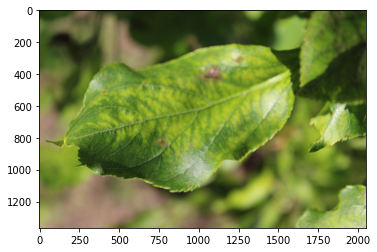

Label: 3


In [ ]:
train_features, train_labels = train_ds[0] 

img = train_features
label = train_labels
plt.imshow(img.permute(1,2,0))
plt.show()
print(f"Label: {label}")

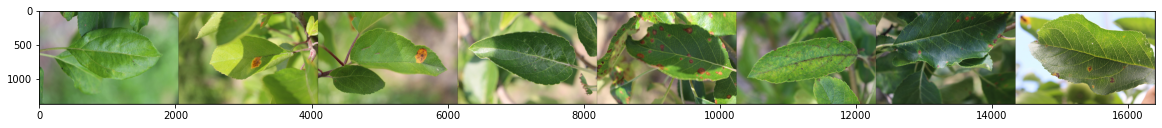

In [ ]:
def imshow(img):         
    #img = img * 0.5 + 0.5 #unnormalize (normalize : (data - 0.5)/0.5))
    plt.figure(figsize=(20, 200))
    plt.imshow(img.permute(1, 2, 0))

dataiter = iter(train_ds_)
dataiter.next()
images, labels = dataiter.next() # 32개의 image, 32개의 label

imshow(torchvision.utils.make_grid(images, nrows=8))

In [ ]:
print(images[0].shape) # C x H x W

torch.Size([3, 1365, 2048])


## 이미지 변환 준비
- Normalize를 위해
- 각 RGB의 mean과 std 를 구한다.

In [ ]:
train_ds = CustomDataset(train_img_path, train_label, train_mode=True, transforms=transforms.ToTensor()) 

val_ds = CustomDataset(valid_img_path, valid_label, train_mode=True, transforms=transforms.ToTensor())

In [ ]:
train_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in train_ds]
train_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in train_ds]

meanR = round(np.mean([m[0] for m in train_meanRGB]),4)
meanG = round(np.mean([m[1] for m in train_meanRGB]),4)
meanB = round(np.mean([m[2] for m in train_meanRGB]),4)
stdR = round(np.std([s[0] for s in train_stdRGB]),4)
stdG = round(np.std([s[1] for s in train_stdRGB]),4)
stdB = round(np.std([s[2] for s in train_stdRGB]),4)

In [ ]:
print(f'meanR : {meanR}, meanG : {meanG}, meanB : {meanB}')
print(f'stdR : {stdR}, stdG : {stdG}, train_stdB : {stdB}')

# 이미지 변경
- 사이즈 800 x 1200
- 0.5 확률 좌우 대칭
- 0.5 확률 상하 대칭
- 0~180도 회전
- 확대
- 텐서로 변환

In [ ]:
from torchvision.transforms.transforms import RandomRotation
train_transform = transforms.Compose([
                    transforms.ToTensor(), 
                    transforms.Resize([CFG['IMG_SIZE_W'], CFG['IMG_SIZE_H']]), 
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.RandomVerticalFlip(p=0.5),
                    transforms.RandomRotation(degrees=(0, 180)),
                    transforms.CenterCrop((CFG['IMG_SIZE_W'], CFG['IMG_SIZE_H'])),
                    transforms.Normalize(mean=(train_meanR, train_meanG, train_meanB), std=(train_stdR, train_stdG, train_stdB))
                    ])

vali_transform = transforms.Compose([
                    transforms.ToTensor(), 
                    transforms.Resize([CFG['IMG_SIZE_W'], CFG['IMG_SIZE_H']]),
                    transforms.Normalize(mean=(vali_meanR, vali_meanG, vali_meanB), std=(vali_stdR, vali_stdG, vali_stdB))
                    ])

test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Resize([CFG['IMG_SIZE_W'], CFG['IMG_SIZE_H']])
                                     ])

In [ ]:
train_ds = CustomDataset(train_img_path, train_label, train_mode=True, transforms=train_transform) 

val_ds = CustomDataset(valid_img_path, valid_label, train_mode=True, transforms=vali_transform) 

test_ds = CustomDataset(test_img_path, valid_label, train_mode=False, transforms=test_transform) 

In [ ]:
train_loader = DataLoader(train_ds, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0) 
vali_loader = DataLoader(val_ds, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)
test_loader = DataLoader(test_ds, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


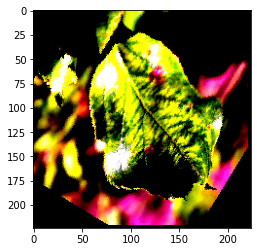

Label: 3


In [ ]:
train_features, train_labels = train_ds[0] 

img = train_features
label = train_labels
plt.imshow(img.permute(1,2,0))
plt.show()
print(f"Label: {label}")

In [ ]:
print(len(train_loader), len(vali_loader))
print(type(train_loader), type(vali_loader))

171 57
<class 'torch.utils.data.dataloader.DataLoader'> <class 'torch.utils.data.dataloader.DataLoader'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


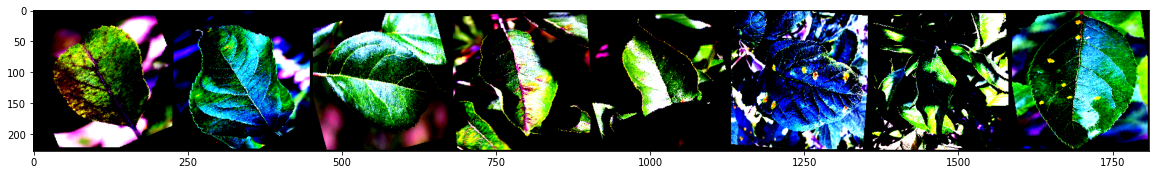

In [ ]:
def imshow(img):         
    plt.figure(figsize=(20, 200))
    plt.imshow(img.permute(1, 2, 0))

dataiter = iter(train_loader)
images, labels = dataiter.next() 

imshow(torchvision.utils.make_grid(images, nrows=8))

# 모델 생성

In [ ]:
from torch import nn
from torch import optim
from torch.nn.modules.dropout import Dropout
import torch.nn.functional as F

cfg = [64,64,'M',128,128,'M',256,256,256,'M',512,512,512,'M',1024,1024,1024,'M',512,512,512,512,'M']

class VGG(nn.Module):
    def __init__(self):
        super().__init__()        
        self.conv1 = self.makemodel_(cfg)
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_features=512, out_features=256), nn.LeakyReLU(),          
            nn.Dropout(0.3),
            nn.Linear(in_features=256, out_features=128), nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(in_features=128, out_features=64), nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features=64, out_features=4),            
        )

    def forward(self, x):
        x = self.conv1(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    

    def makemodel_(self, cfg):
        layers = []
        in_channels=3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else :
                layers += [nn.Conv2d(in_channels=in_channels, out_channels=x, kernel_size=3, padding=1),
                            nn.BatchNorm2d(num_features=x),
                            nn.Dropout2d(0.2, inplace=True),
                            nn.LeakyReLU(inplace=True)]
                in_channels = x
        layers += [nn.AdaptiveAvgPool2d((1,1))]

        # 64*400*600  >  64*200*300
        # 64*200*300  >  128*100*150
        # 128*100*150   >  256*50*75 
        # 256*50*75   >  512*25*38 
        # 512*25*38   >  1024*13*19
        # 1024*13*19   >  512*6*9
        # 512*6*9abs     >  512*1*1
        return nn.Sequential(*layers)

In [ ]:
model = VGG19()
model.to(device) # model을 GPU로 보내기

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2_x): Sequential(
    (0): BottleNeck(
      (residual_function): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
        (6): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential(
     

In [ ]:
from torchsummary import summary
summary(model, (3, CFG['IMG_SIZE_W'], CFG['IMG_SIZE_H']))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

# 모델 훈련

In [ ]:
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import roc_auc_score
writer = SummaryWriter()

def validation(model, testloader, criterion):
    test_accuracy = 0
    test_loss = 0
    true_onehot_list = []
    pred_list = []
    with torch.no_grad(): # 예측에는 gradient가 필요 없음
        for images, labels in testloader: # 1 iteration마다 배치 단위로 image와 label을 가져옴
            images, labels = images.to(device), labels.to(device) # data를 GPU로 보내기
            # Not Flatten!!!
            #images.resize_(images.shape[0], 784) # batch size x 784
            
            logits = model.forward(images) # 입력 : batch_size, 28, 28
            
            loss = criterion(logits, labels)
            test_loss += loss.item()

            probs = F.softmax(logits, dim=1)
            
            true_onehot = torch.eye(4)[labels].cpu().numpy()
            preds_ = torch.softmax(logits.cpu(), dim=1).numpy()

            pred_list.extend(preds_)
            true_onehot_list.extend(true_onehot)
            
            _, preds = torch.max(probs, 1) # preds = probs.max(dim=1)[1]
            correct = (preds == labels).sum()
            accuracy = correct / images.shape[0]
            test_accuracy += accuracy
        test_auc = roc_auc_score(true_onehot_list, pred_list)
    return test_loss, test_accuracy, test_auc     

In [ ]:
learning_rate = CFG['LEARNING_RATE']
criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=CFG['SCHEDULER'], factor=0.1, verbose=True)

In [ ]:
# 모델 저장 폴더 생성
import os
try:
    os.mkdir('model_saved')
except:
    pass

In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

vali_acc=[]
vali_loss=[]

def train(model, epochs, criterion, optimizer):
    global vali_acc, vali_loss
    steps = 0
 
    # 1 에폭(epoch)당 반복수
    #iter_per_epoch = len(trainset) / batch_size  
    iter_per_epoch = len(train_loader) 
    print_every = iter_per_epoch
    best_auc = 0
    valid_auc = 0

    # for Early stopping
    min_loss = 1000
    trigger = 0
    patience = CFG['PATIENCE']

    # learning
    valid_loss = 0
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, labels in tqdm(iter(train_loader)):
            steps += 1
            images, labels = images.to(device), labels.to(device)

            
            optimizer.zero_grad()

            # 1. Forward (Loss 얻게됨)
            output = model.forward(images)
            loss = criterion(output, labels)

            # 2. Backward (Gradient가 오차역전파로 구해짐)
            loss.backward()

            # 3. Gradient Descent (Model parameter update) :  W <- W-lr*Gradient
            optimizer.step() 

            train_loss += loss.item() # 1 epoch 당 누적된 로스
            
            if steps % print_every == 0 : 
                 # 배치 정규화, 드롭아웃 이 적용될 경우 model.forward 연산이 training 때와 다르므로 반드시 설정
                model.eval()
                valid_loss, valid_accuracy, valid_auc = validation(model, vali_loader, criterion)
                
                vali_acc.append(valid_accuracy/len(vali_loader))
                vali_loss.append(valid_loss/len(vali_loader))

                writer.add_scalar("Loss/train", train_loss/len(train_loader), epoch)
                writer.add_scalar("Loss/test", valid_loss/len(vali_loader), epoch)
                writer.add_scalars("Loss/train and valid",
                                { "train" : train_loss/len(train_loader),
                                    "test" : valid_loss/len(vali_loader) }, epoch)
                writer.add_scalar("test_roc_auc", valid_auc, epoch)

                print("Epoch : {}/{}...".format(epoch+1, epochs),
                    " Train Loss : {:.3f}".format(train_loss/len(train_loader) ),
                    " Valid Loss : {:.3f}".format(valid_loss/len(vali_loader)),
                    " Valid Accuracy : {:.3f}".format(valid_accuracy/len(vali_loader)),
                    " Valid AUC_ROC :  {:.3f}".format(valid_auc))
                
                # Early stopping Start 
                if valid_loss > min_loss: 
                    trigger +=1
                    print("trigger :", trigger)
                    if trigger > patience: 
                        print("Early Stopping!!!")
                        print("Train step is finished!!")
                        writer.flush()
                        writer.close() 
                        return
                else: 
                    min_loss = valid_loss
                    trigger = 0
                
                # Early stopping End
                train_loss = 0
                model.train()
            # Best model 저장
            if valid_auc > best_auc:
                torch.save(model.state_dict(), dir+"best_model_VGG.pth")
                best_auc = valid_auc
            

        # Learning Rate Scheduler 
        scheduler.step(valid_loss)
    writer.flush()
    writer.close()        

In [ ]:
train(model, CFG['EPOCHS'], criterion, optimizer)

 99%|█████████▉| 170/171 [01:39<00:00,  1.71it/s]

Epoch : 1/150...  Train Loss : 10.167  Valid Loss : 10.671  Valid Accuracy : 0.344  Valid AUC_ROC :  0.542


 99%|█████████▉| 170/171 [01:28<00:00,  1.93it/s]

Epoch : 2/150...  Train Loss : 10.073  Valid Loss : 9.963  Valid Accuracy : 0.386  Valid AUC_ROC :  0.633


 99%|█████████▉| 170/171 [01:28<00:00,  1.93it/s]

Epoch : 3/150...  Train Loss : 10.026  Valid Loss : 10.026  Valid Accuracy : 0.417  Valid AUC_ROC :  0.691
trigger : 1


100%|██████████| 171/171 [01:50<00:00,  1.55it/s]


Epoch : 4/150...  Train Loss : 9.891  Valid Loss : 10.354  Valid Accuracy : 0.364  Valid AUC_ROC :  0.635
trigger : 2


 99%|█████████▉| 170/171 [01:26<00:00,  1.95it/s]

Epoch : 5/150...  Train Loss : 9.819  Valid Loss : 9.263  Valid Accuracy : 0.461  Valid AUC_ROC :  0.672


 99%|█████████▉| 170/171 [01:27<00:00,  1.94it/s]

Epoch : 6/150...  Train Loss : 9.687  Valid Loss : 8.892  Valid Accuracy : 0.504  Valid AUC_ROC :  0.706


100%|██████████| 171/171 [01:51<00:00,  1.53it/s]


Epoch : 7/150...  Train Loss : 9.452  Valid Loss : 9.990  Valid Accuracy : 0.412  Valid AUC_ROC :  0.636
trigger : 1


100%|██████████| 171/171 [01:51<00:00,  1.54it/s]


Epoch : 8/150...  Train Loss : 9.449  Valid Loss : 8.875  Valid Accuracy : 0.496  Valid AUC_ROC :  0.732


100%|██████████| 171/171 [01:51<00:00,  1.53it/s]


Epoch : 9/150...  Train Loss : 9.391  Valid Loss : 9.454  Valid Accuracy : 0.447  Valid AUC_ROC :  0.709
trigger : 1


 99%|█████████▉| 170/171 [01:27<00:00,  1.96it/s]

Epoch : 10/150...  Train Loss : 9.300  Valid Loss : 8.684  Valid Accuracy : 0.535  Valid AUC_ROC :  0.756


 99%|█████████▉| 170/171 [01:27<00:00,  1.97it/s]

Epoch : 11/150...  Train Loss : 9.361  Valid Loss : 8.652  Valid Accuracy : 0.539  Valid AUC_ROC :  0.743


 99%|█████████▉| 170/171 [01:27<00:00,  1.95it/s]

Epoch : 12/150...  Train Loss : 9.222  Valid Loss : 8.409  Valid Accuracy : 0.568  Valid AUC_ROC :  0.759


100%|██████████| 171/171 [01:51<00:00,  1.53it/s]


Epoch : 13/150...  Train Loss : 9.005  Valid Loss : 8.666  Valid Accuracy : 0.542  Valid AUC_ROC :  0.748
trigger : 1


 99%|█████████▉| 170/171 [01:27<00:00,  1.95it/s]

Epoch : 14/150...  Train Loss : 8.867  Valid Loss : 8.257  Valid Accuracy : 0.592  Valid AUC_ROC :  0.769


100%|██████████| 171/171 [01:51<00:00,  1.54it/s]


Epoch : 15/150...  Train Loss : 8.638  Valid Loss : 8.273  Valid Accuracy : 0.548  Valid AUC_ROC :  0.767
trigger : 1


100%|██████████| 171/171 [01:51<00:00,  1.54it/s]


Epoch : 16/150...  Train Loss : 8.640  Valid Loss : 9.046  Valid Accuracy : 0.526  Valid AUC_ROC :  0.681
trigger : 2


100%|██████████| 171/171 [01:51<00:00,  1.54it/s]


Epoch : 17/150...  Train Loss : 8.466  Valid Loss : 8.077  Valid Accuracy : 0.581  Valid AUC_ROC :  0.761


100%|██████████| 171/171 [01:50<00:00,  1.55it/s]


Epoch : 18/150...  Train Loss : 8.063  Valid Loss : 8.211  Valid Accuracy : 0.579  Valid AUC_ROC :  0.769
trigger : 1


 99%|█████████▉| 170/171 [01:26<00:00,  1.95it/s]

Epoch : 19/150...  Train Loss : 7.952  Valid Loss : 7.503  Valid Accuracy : 0.638  Valid AUC_ROC :  0.798


100%|██████████| 171/171 [01:50<00:00,  1.55it/s]


Epoch : 20/150...  Train Loss : 7.347  Valid Loss : 8.928  Valid Accuracy : 0.638  Valid AUC_ROC :  0.766
trigger : 1


 99%|█████████▉| 170/171 [01:26<00:00,  1.97it/s]

Epoch : 21/150...  Train Loss : 6.806  Valid Loss : 6.400  Valid Accuracy : 0.711  Valid AUC_ROC :  0.825


 99%|█████████▉| 170/171 [01:26<00:00,  1.95it/s]

Epoch : 22/150...  Train Loss : 6.251  Valid Loss : 5.240  Valid Accuracy : 0.750  Valid AUC_ROC :  0.849


100%|██████████| 171/171 [01:50<00:00,  1.54it/s]


Epoch : 23/150...  Train Loss : 5.583  Valid Loss : 5.415  Valid Accuracy : 0.746  Valid AUC_ROC :  0.862
trigger : 1


100%|██████████| 171/171 [01:50<00:00,  1.55it/s]


Epoch : 24/150...  Train Loss : 5.225  Valid Loss : 5.164  Valid Accuracy : 0.741  Valid AUC_ROC :  0.891


 99%|█████████▉| 170/171 [01:26<00:00,  1.96it/s]

Epoch : 25/150...  Train Loss : 4.722  Valid Loss : 4.317  Valid Accuracy : 0.807  Valid AUC_ROC :  0.880


 99%|█████████▉| 170/171 [01:27<00:00,  1.96it/s]

Epoch : 26/150...  Train Loss : 4.728  Valid Loss : 4.094  Valid Accuracy : 0.827  Valid AUC_ROC :  0.900


100%|██████████| 171/171 [01:50<00:00,  1.55it/s]


Epoch : 27/150...  Train Loss : 4.617  Valid Loss : 4.874  Valid Accuracy : 0.803  Valid AUC_ROC :  0.867
trigger : 1


100%|██████████| 171/171 [01:50<00:00,  1.55it/s]


Epoch : 28/150...  Train Loss : 4.054  Valid Loss : 3.723  Valid Accuracy : 0.827  Valid AUC_ROC :  0.900


100%|██████████| 171/171 [01:49<00:00,  1.56it/s]


Epoch : 29/150...  Train Loss : 4.072  Valid Loss : 4.147  Valid Accuracy : 0.803  Valid AUC_ROC :  0.895
trigger : 1


100%|██████████| 171/171 [01:49<00:00,  1.56it/s]


Epoch : 30/150...  Train Loss : 4.076  Valid Loss : 4.384  Valid Accuracy : 0.811  Valid AUC_ROC :  0.881
trigger : 2


 99%|█████████▉| 170/171 [01:26<00:00,  1.98it/s]

Epoch : 31/150...  Train Loss : 3.675  Valid Loss : 3.800  Valid Accuracy : 0.838  Valid AUC_ROC :  0.897
trigger : 3


 99%|█████████▉| 170/171 [01:26<00:00,  1.93it/s]

Epoch : 32/150...  Train Loss : 3.750  Valid Loss : 3.495  Valid Accuracy : 0.851  Valid AUC_ROC :  0.917


 99%|█████████▉| 170/171 [01:26<00:00,  1.96it/s]

Epoch : 33/150...  Train Loss : 3.607  Valid Loss : 4.105  Valid Accuracy : 0.860  Valid AUC_ROC :  0.906
trigger : 1


100%|██████████| 171/171 [01:51<00:00,  1.54it/s]


Epoch : 34/150...  Train Loss : 3.413  Valid Loss : 3.942  Valid Accuracy : 0.831  Valid AUC_ROC :  0.880
trigger : 2


100%|██████████| 171/171 [01:50<00:00,  1.54it/s]


Epoch : 35/150...  Train Loss : 3.228  Valid Loss : 3.668  Valid Accuracy : 0.836  Valid AUC_ROC :  0.902
trigger : 3


 99%|█████████▉| 170/171 [01:26<00:00,  1.96it/s]

Epoch : 36/150...  Train Loss : 3.417  Valid Loss : 3.535  Valid Accuracy : 0.864  Valid AUC_ROC :  0.910
trigger : 4


100%|██████████| 171/171 [01:50<00:00,  1.54it/s]


Epoch : 37/150...  Train Loss : 2.988  Valid Loss : 3.146  Valid Accuracy : 0.862  Valid AUC_ROC :  0.923


  3%|▎         | 5/171 [00:02<01:25,  1.95it/s]

# 모델 평가

In [ ]:
def evaluate(model, testloader):
    test_accuracy = 0
    test_loss = 0
    true_onehot_list = []
    pred_list = []
    model.eval()
    with torch.no_grad(): # 예측에는 gradient가 필요 없음
        for images, labels in testloader: # 1 iteration마다 배치 단위로 image와 label을 가져옴
            images, labels = images.to(device), labels.to(device)
            # not Flatten!
            #images.resize_(images.shape[0], 784) # batch size x 784
            logits = model.forward(images) # 입력 : batch * height * width
            
            loss = criterion(logits, labels)
            test_loss += loss.item()

            true_onehot = torch.eye(4)[labels].cpu().numpy()
            preds_ = torch.softmax(logits.cpu(), dim=1).numpy()

            pred_list.extend(preds_)
            true_onehot_list.extend(true_onehot)

            probs = F.softmax(logits, dim=1)
            _, preds = torch.max(probs, 1) # preds = probs.max(dim=1)[1]

            correct = (preds == labels).sum()
            accuracy = correct / images.shape[0]
            test_accuracy += accuracy.item()

        test_auc = roc_auc_score(true_onehot_list, pred_list)
    print("Test Loss : ", test_loss/len(testloader))
    print("Accuracy : ", test_accuracy/len(testloader))
    print("AUC_ROC : ", test_auc)
    return pred_list

In [ ]:
# 마지막 학습결과를 저장 후 나중에 사용하기 원할 때
torch.save(model.state_dict(), dir"last_checkpoint_VGG.pth")
state_dict = torch.load(dir+"last_checkpoint_VGG.pth") 
last_model = VGG() # 이미 model에 마지막 학습결과가 있으나 last_model로 다시 불러옴
last_model.to(device)
last_model.load_state_dict(state_dict) # model과 parameter를 매치 시키는 작업
test_preds=evaluate(last_model, test_loader)

In [ ]:
# Test Accuracy 기준으로 가장 높을때의 모델 파라미터가 저장되어 있음
state_dict = torch.load(dir+"best_checkpoint_VGG.pth") 
best_model = resnet101()
best_model.to(device)
best_model.VGG(state_dict)
test_preds=evaluate(best_model, test_loader)